In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from tqdm.notebook import tqdm
print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.2.2; Torch-cuda version: None; Torch Geometric version: 2.5.2.


In [2]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, serendipity, diversity, catalog_coverage, distributional_coverage, novelty

In [13]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
lgc_stats_random = pickle.load(open(f"model_stats/LGCN_LGC_3_e64_nodes157075__BCE_random.pkl", "rb"))
lgc_stats_hard = pickle.load(open(f"model_stats/LGCN_LGC_3_e64_nodes157075__BPR_hard.pkl", "rb"))


In [14]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

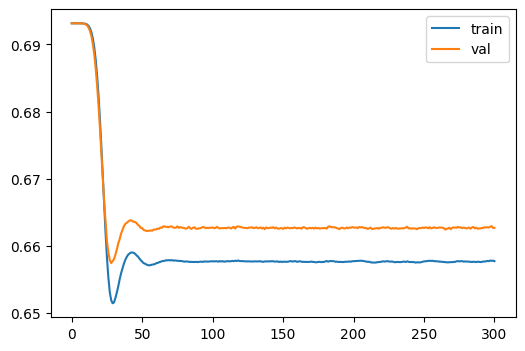

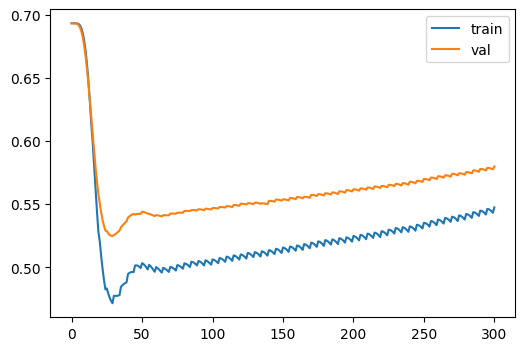

In [15]:
plot_train_val_loss(lgc_stats_random)

plot_train_val_loss(lgc_stats_hard)

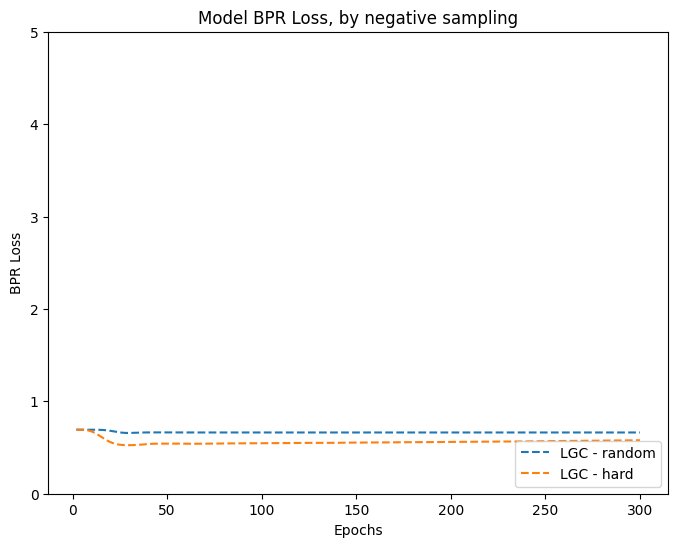

In [16]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats_random["val"][key])).rolling(3).mean()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss, color = colors[1], linestyle = 'dashed', label = "LGC - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by negative sampling")
ax.set_ylim(0, 5)
plt.show()

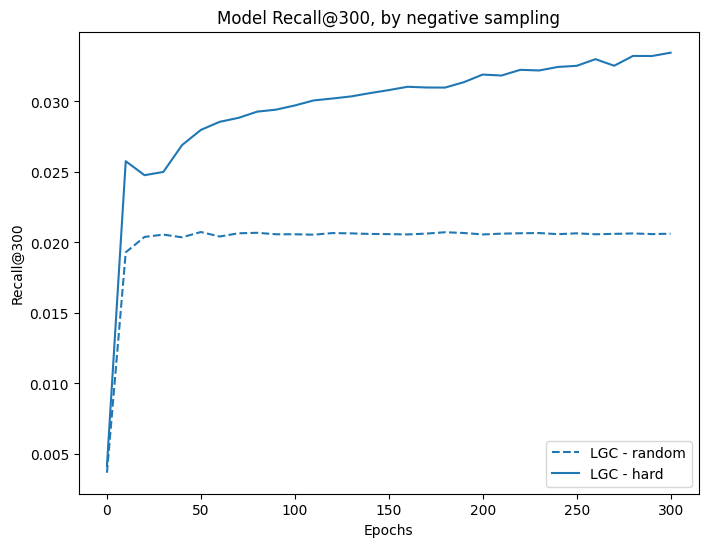

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats_random["val"][key]
lgc_hard_recall = lgc_stats_hard["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_recall, color = colors[0], label = "LGC - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall@300, by negative sampling")
plt.show()

In [20]:
lgc_stats_random

{'train': {'loss': [tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6931, requires_grad=True),
   tensor(0.6929, requires_grad=True),
   tensor(0.6927, requires_grad=True),
   tensor(0.6924, requires_grad=True),
   tensor(0.6918, requires_grad=True),
   tensor(0.6909, requires_grad=True),
   tensor(0.6895, requires_grad=True),
   tensor(0.6877, requires_grad=True),
   tensor(0.6853, requires_grad=True),
   tensor(0.6824, requires_grad=True),
   tensor(0.6789, requires_grad=True),
   tensor(0.6749, requires_grad=True),
   tensor(0.6706, requires_grad=True),
   tensor(0.6662, requires_grad=True),
   tensor(0.6619, requires_grad=True),
   tenso

**use this embedding after final epoch**

In [3]:
embedding_path = 'model_stats/LGCN_LGC_3_e64_nodes157075__BPR_hard.pt'
loaded_embeds = torch.load(embedding_path, map_location="cpu")
print(loaded_embeds.keys())

odict_keys(['alpha', 'embedding.weight'])


In [4]:
loaded_embeds['embedding.weight']

tensor([[ 0.1604,  0.2843,  0.0480,  ...,  0.0426,  0.0383,  0.1232],
        [ 0.0962,  0.0096,  0.0598,  ...,  0.0186, -0.0191, -0.0654],
        [ 0.0220,  0.0448, -0.0037,  ..., -0.0289, -0.0308, -0.0167],
        ...,
        [-0.0158, -0.0499, -0.0079,  ..., -0.0212, -0.0071, -0.0036],
        [ 0.0382,  0.0449,  0.0195,  ...,  0.0207,  0.0259,  0.0373],
        [ 0.0480,  0.0642,  0.0290,  ...,  0.0329,  0.0387,  0.0567]])

In [5]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
data = pd.read_csv('../Data/user_songs_filtered.csv')
data = data.sort_values(by = 'Username')
data = data.reset_index(drop=True)

In [7]:
class Track:
  def __init__(self, track_dict):
    self.name = track_dict["track_name"]
    self.artist_name = track_dict["artist_name"]
    self.listeners = track_dict["listeners"]
    self.total_playcount = track_dict["total_playcount"]
    self.emotion1 = track_dict["emotion1"]
    self.emotion1_score = track_dict["emotion1_score"]
    self.emotion2 = track_dict["emotion2"]
    self.emotion2_score = track_dict["emotion2_score"]
    self.rms = track_dict["rms"]
    self.spectral_centroid	= track_dict['spectral_centroid']
    self.tempo = track_dict['tempo']

  def __str__(self):
    return f"Track called {self.name} by ({self.artist_name}) has emotions {self.emotion1} and {self.emotion2}."

  def __repr__(self):
    return f"Track {self.name}"

  def __lt__(self, other):
    return (self.name < other.name) and (self.total_playcount < other.total_playcount)

  def __gt__(self, other):
    return (self.name > other.name) and (self.total_playcount > other.total_playcount)
  
data[['track_name', 'artist_name']].drop_duplicates().to_numpy()

tracks = []
unique_tracks = data[['track_name', 'artist_name']].drop_duplicates().to_numpy()
for track, artist in tqdm(unique_tracks):
    row_data = data.loc[(data['track_name'] == track) & (data['artist_name'] == artist)].iloc[0]
    track_data = row_data[['track_name', 'artist_name', 'listeners', 'total_playcount', 'emotion1', 'emotion1_score',
                           'emotion2', 'emotion2_score', 'rms', 'spectral_centroid', 'tempo']].to_dict()
    tracks += [Track(track_data)]


  0%|          | 0/147592 [00:00<?, ?it/s]

In [8]:

class User:
  def __init__(self, user_data, top_songs):

    self.name = user_data['Username']
    self.country = user_data['country']
    self.track_count = int(user_data['track_count'])
    self.total_playcount = 0
    self.top_songs = {}
    self.artists = []
    for index, row in top_songs.iterrows():
      rank = row['rank']
      track_name = row['track_name']
      artist_name = row['artist_name']
      track = [obj for obj in tracks if (obj.name == track_name)&(obj.artist_name == artist_name)][0]
      playcount = row['playcount']
      self.top_songs[rank] = (track, playcount)
      self.total_playcount += playcount
      # or should i use a dict for artists
      self.artists +=[artist_name]

    self.top_songs =  {k: self.top_songs[k] for k in sorted(self.top_songs)}
  def __str__(self):
    return f"User {self.name} with {len(self.top_songs)} top tracks loaded, total listen count is {self.total_playcount}."

  def __repr__(self):
    return f"User {self.name}"
  def __lt__(self, other):
    return (self.name < other.name) and (self.total_playcount < other.total_playcount)

  def __gt__(self, other):
    return (self.name > other.name) and (self.total_playcount > other.total_playcount)


In [9]:

unique_users = data.Username.unique()
users = []
for user in tqdm(unique_users):
    user_data = data.loc[data['Username'] == user].iloc[0]
    user_data = user_data[['Username', 'country', 'track_count']].to_dict()
    top_songs = data.loc[data['Username'] == user]
    top_songs = top_songs[['rank', 'track_name', 'artist_name', 'playcount']]
    users +=[User(user_data, top_songs)]

  0%|          | 0/9483 [00:00<?, ?it/s]

In [10]:
# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "user"}) for p in users
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

# adding edges
for user in users:
  top_songs = user.top_songs
  user_total_listening = user.total_playcount
  for song, count in top_songs.values():
    G.add_edge(user, song, weight=1 / (count/user_total_listening))


# Make a large subgraph
random.seed(225)
rand_nodes_lg = random.sample(list(G.nodes()), 3000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())


n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = list(G.nodes())

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)

# also keep track of how many users, tracks we have
users_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, User)] 
tracks_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, Track)]
n_users = np.max(users_idx) + 1
n_tracks = n_nodes - n_users

n_users, n_tracks

# turn the graph into a torch_geometric Data object
num_nodes = G.number_of_nodes()
edge_idx = torch.Tensor(np.array(G.edges()).T)
# Get the edge weights from the NetworkX graph
edge_weights = []
for u, v in G.edges():
    edge_weights.append(G[u][v]['weight'])
edge_weights = torch.tensor(edge_weights, dtype=torch.float)
print(edge_weights)
graph_data = Data(edge_index = edge_idx, edge_weight = edge_weights, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)
for split_data in [train_split, val_split, test_split]:
    edge_weights_split = []
    for u, v in split_data.edge_index.T:
        edge_weights_split.append(G[node2id[id2node[u.item()]]][node2id[id2node[v.item()]]]['weight'])
    split_data.edge_weight = torch.tensor(edge_weights_split, dtype=torch.float)


# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")


Large subgraph Num nodes: 10 . Num edges: 9
tensor([20.5141, 25.7788, 26.7248,  ..., 52.7391, 52.7391, 52.7391])
Train set has 275184 positives supervision edges
Validation set has 58968 positive supervision edges
Test set has 58968 positive supervision edges
Train set has 550368 message passing edges
Validation set has 550368 message passing edges
Test set has 668304 message passing edges


In [57]:
user_embeddings = loaded_embeds['embedding.weight'][:n_users]
tracks_embeddings = loaded_embeds['embedding.weight'][n_users:]

In [59]:
song_features = pd.read_csv('../Data/unique_songs_features_complete.csv')
song_features

,track_name_original,artist_name_original,lyrics,duration_ms,listeners,total_playcount,toptags,profanity_density,polarity,subjectivity,emotion1,emotion1_score,emotion2,emotion2_score,mfcc,chroma,rms,spectral_centroid,zcr,tempo
0,One Look,Leo,you could be the love of my life\ntell me im n...,156000.0,8973.0,88557.0,"['pop', 'english', 'leodasun']",0.000000,-0.00143,0.50357,positive,0.129932,negative,0.071952,[-94.341545 131.62889 -22.428738 50.27...,[0.45004523 0.45005292 0.57855475 0.5422693 0...,0.275240,2978.396347,0.062171,129.199219
1,Cradle,Mudvayne,breathe breathe breathe breathe\npush push pus...,314000.0,86366.0,368525.0,"['Nu Metal', 'metal', 'math metal', 'alternati...",0.040936,-0.28963,0.66382,negative,0.111774,disgust,0.054927,[-153.13193 125.41709 -35.41838 4...,[0.610627 0.52234715 0.48563012 0.516958 0...,0.151819,3075.841535,0.077126,172.265625
2,Reading YouTube Comments,Drug Church,it glows in the center\nbut they havent invent...,172000.0,7399.0,38545.0,[],0.000000,-0.12500,0.34375,negative,0.234642,fear,0.171831,[-72.94578 126.77503 -46.73466 45.38...,[0.5410768 0.56112826 0.5285746 0.5264109 0...,0.249417,3382.053061,0.078146,178.205819
3,Tissues,YUNGBLUD,i feel left out\nlike a child\nevery time that...,0.0,59233.0,481214.0,"['seen live', 'rock']",0.000000,0.03286,0.58913,positive,0.178898,joy,0.143101,[-29.943943 134.54782 -46.5182 55.03...,[0.4032532 0.40510523 0.33724827 0.41406393 0...,0.318193,3362.386296,0.078008,90.666118
4,The Games We Play,Pusha T,drug dealer benzes with gold diggers in em\nin...,166000.0,270156.0,2858530.0,"['hardcore hip hop', 'rap', 'Energetic', 'Gang...",0.022523,0.08550,0.46763,positive,0.156240,joy,0.073203,[-86.60968 117.12216 -40.658672 45.47...,[0.2931717 0.31128934 0.44186398 0.3576136 0...,0.300682,3379.955173,0.072801,156.605114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230671,Come Out Ye Black & Tans,The Wolfe Tones,\ni was born on a dublin street where the loya...,178000.0,36640.0,241115.0,"['irish', 'silver apples moon', 'folk', 'celti...",0.000000,0.10397,0.47579,trust,0.124464,negative,0.109407,[-55.630116 152.09698 -36.875008 45.84...,[0.46496058 0.4006875 0.3544472 0.5362833 0...,0.285878,2723.316107,0.060667,95.703125
230672,Pink Sky (Can I Tell You Something?),Be Good,\n go\n\n \nid tell you to stay\ncause ive b...,131000.0,76.0,471.0,[],0.002242,0.02654,0.53865,negative,0.176048,positive,0.126093,[-9.6058380e+01 1.5916463e+02 -3.8661049e+01 ...,[0.53047025 0.4547887 0.48685956 0.43063146 0...,0.232772,2445.767406,0.051347,132.512019
230673,Sink With You,Underoath,this is my emergency\nlet me feel your apathy\...,0.0,15350.0,141388.0,"['metalcore', 'hardcore', 'emo', 'screamo', 'c...",0.000000,0.40741,0.51204,negative,0.089753,sadness,0.062062,[-33.553635 134.06999 -47.291656 52.29...,[0.55731076 0.47342858 0.49472496 0.46570522 0...,0.290397,3349.353744,0.075943,77.133862
230674,Endseekers,"Oh, Sleeper",\npry your eyes and behold our captain rally r...,186000.0,36782.0,235203.0,"['metalcore', 'post-hardcore', 'Christian Meta...",0.000000,0.01111,0.44120,positive,0.209360,negative,0.144061,[-26.104374 148.44427 -64.71878 56.90...,[0.530011 0.45531207 0.5422821 0.52246004 0...,0.334792,2931.256543,0.070598,95.703125


In [61]:
list = []
for batch_start in range(0, n_users, 64):
    batch_end = min(batch_start + 64, n_users)
    batch_users_embeddings = user_embeddings[batch_start:batch_end]
    scores = torch.matmul(batch_users_embeddings, tracks_embeddings.t())
    mp_indices = ((train_split.edge_index[0] >= batch_start) & (train_split.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
    scores[train_split.edge_index[0, mp_indices] - batch_start, train_split.edge_index[1, mp_indices] - n_users] = -float("inf")
    _, top_k_indices = torch.topk(scores, 30, dim=1)
    for i in range(batch_end - batch_start):
        user_id = i + batch_start
        top_k_rec = top_k_indices[i]
        dict = {}
        dict['UserId'] = user_id
        dict['ItemId'] = top_k_rec.to
        list += [dict]


In [65]:
top = pd.DataFrame(list).explode(column = 'ItemId')
top['ItemId'] = top['ItemId'].astype(int)

In [72]:
top_cleaned = top[~top.isin(ground_truth_edges)].dropna()

In [86]:
df_all = top.merge(ground_truth_edges.drop_duplicates(), on=['UserId','ItemId'], 
                   how='left', indicator=True)
top_cleaned = df_all.loc[df_all['_merge'] == 'left_only']

In [75]:
top_cleaned = top_cleaned.astype(int)

In [92]:
ground_truth_edges = train_split.edge_label_index
ground_truth_edges= {'UserId': ground_truth_edges[0], 'ItemId': ground_truth_edges[1]}
ground_truth_edges = pd.DataFrame(ground_truth_edges)

In [87]:
ground_truth_edges = train_split.edge_label_index
ground_truth_edges= {'UserId': ground_truth_edges[0], 'ItemId': ground_truth_edges[1]}
ground_truth_edges = pd.DataFrame(ground_truth_edges)
# rec_k = pd.DataFrame(dict)
div_args = [ground_truth_edges, top_cleaned]
diversity_eval = diversity(*div_args, col_user="UserId",
    col_item="ItemId")
print(f"Diversity: {diversity_eval}")

Diversity: 0.9992792605748213



We define _catalog coverage_ as the proportion of items showing in all users’ recommendations:
$$
\textrm{CatalogCoverage} = \frac{|N_r|}{|N_t|}
$$
where $N_r$ denotes the set of items in the recommendations (`top_k` in the code below) and $N_t$ the set of items in the historical data (`train`).

_Distributional coverage_ measures how equally different items are recommended to users when a particular recommender system is used.
If  $p(i|R)$ denotes the probability that item $i$ is observed among all recommendation lists, we define distributional coverage as
$$
\textrm{DistributionalCoverage} = -\sum_{i \in N_t} p(i|R) \log_2 p(i)
$$
where
$$
p(i|R) = \frac{|M_r (i)|}{|\textrm{train}|}
$$
and $M_r (i)$ denotes the users who are recommended item $i$.


In [88]:
cov_args = [ground_truth_edges, rec_k]
cat_coverage = catalog_coverage(*cov_args, col_user="UserId",
    col_item="ItemId")
dist_coverage = distributional_coverage(*cov_args, col_user="UserId",
    col_item="ItemId")
print(f"Catalog Coverage: {cat_coverage} \nDistributional Coverage: {dist_coverage}")

Catalog Coverage: 0.00025933609958506224 
Distributional Coverage: 4.906890595608519



**Novelty**

The novelty of an item is inverse to its _popularity_. If $p(i)$ represents the probability that item $i$ is observed (or known, interacted with etc.) by users, then  
$$
p(i) = \frac{|M_t (i)|} {|\textrm{train}|}
$$
where $M_t (i)$ is the set of users who have interacted with item $i$ in the historical data.

The novelty of an item is then defined as
$$
\textrm{novelty}(i) = -\log_2 p(i)
$$
and the novelty of the recommendations across all users is defined as
$$
\textrm{novelty} = \sum_{i \in N_r} \frac{|M_r (i)|}{|\textrm{top_k}|} \textrm{novelty}(i)
$$


In [90]:
nov_args = [ground_truth_edges, rec_k]
novelty_eval = novelty(*nov_args, col_user="UserId",
    col_item="ItemId")
print(f"Novelty: {novelty_eval}")

Novelty: 1.0323383042465741


**Serendipity**

Serendipity represents the “unusualness” or “surprise” of recommendations. Unlike novelty, serendipity encompasses the semantic content of items and can be imagined as the distance between recommended items and their expected contents (Zhang et al.) Lower cosine similarity indicates lower expectedness and higher serendipity.
We define the expectedness of an unseen item $i$ for user $u$ as the average similarity between every already seen item $j$ in the historical data and $i$:
$$
\textrm{expectedness}(i|u) = \frac{1}{|N_t (u)|} \sum_{j \in N_t (u)} \textrm{Cosine Similarity}(i,j)
$$
The serendipity of item $i$ is (1 - expectedness) multiplied by _relevance_, where relevance indicates whether the item turns out to be liked by the user or not. For example, in a binary scenario, if an item in `top_k` is liked (purchased, clicked) in `train`, its relevance equals one, otherwise it equals zero. Aggregating over all users and items, the overall
serendipity is defined as
$$
\textrm{serendipity} = \frac{1}{|M|} \sum_{u \in M_r}
\frac{1}{|N_r (u)|} \sum_{i \in N_r (u)} \big(1 - \textrm{expectedness}(i|u) \big) \, \textrm{relevance}(i)
$$


In [91]:
ser_args = [ground_truth_edges, rec_k]
ser_eval = serendipity(*ser_args, col_user="UserId",
    col_item="ItemId")
print(f"Serendipity: {ser_eval}")

Serendipity: 0.9999525370183135
